# Johnson-Lindenstrauss (JL) Dimensionality Reduction + ANN

This notebook evaluates approximate nearest neighbor search using Johnson-Lindenstrauss random projection for dimensionality reduction, followed by brute-force search in the lower-dimensional space.

## Method
1. Apply JL projection: X_train → X_train_projected (d → k dimensions)
2. Build KNN index in k-dimensional space
3. Project query vectors and search in k-dimensional space

## Metrics
- **Recall@10**: Proportion of true nearest neighbors retrieved
- **Query time**: Time per query (including projection) in milliseconds
- **Build time**: Time to construct projection + index
- **Memory**: Total memory footprint in MB

## Target Dimensions by Dataset
- **SIFT (128-dim)**: k ∈ {32, 48, 64, 80, 96, 112}
- **GIST (960-dim)**: k ∈ {100, 200, 300, 400, 600, 800}
- **Deep1B (96-dim)**: k ∈ {32, 48, 64, 80}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.random_projection import SparseRandomProjection
import time
import sys
import json
import os

# Import our custom modules
sys.path.append('..')  # If running from notebooks/ subdirectory
from evaluator import ANNEvaluator
from datasets import DatasetLoader, print_dataset_info

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 10)

print("Imports successful!")

Imports successful!


## 1. Configuration

In [ ]:
# Configuration
K = 1  # Number of nearest neighbors
DATA_DIR = "data"  # Adjust if needed

# Which datasets to evaluate
DATASETS = [
    'sift',
    'gist',
    'deep1b'
]

# Target dimensions for each dataset (k < d)
TARGET_DIMS = {
    'sift': [32, 48, 64, 80, 96, 112],     # Original: 128
    'gist': [100, 200, 300, 400, 600, 800], # Original: 960
    'deep1b': [32, 48, 64, 80]              # Original: 96
}

# Subset sizes (None = use full dataset)
N_TRAIN = None  # Use full training set
N_TEST = 1000   # Use 1000 test queries for faster evaluation

# JL Projection parameters
JL_EPSILON = 0.1  # Distance preservation parameter (smaller = more dimensions needed)
JL_DENSITY = 'auto'  # Sparsity of random matrix ('auto' recommended)

# Results directory
RESULTS_DIR = "../results"
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"Configuration:")
print(f"  k (neighbors) = {K}")
print(f"  JL epsilon = {JL_EPSILON}")
print(f"  Datasets: {DATASETS}")
print(f"  Training samples: {N_TRAIN if N_TRAIN else 'all'}")
print(f"  Test queries: {N_TEST if N_TEST else 'all'}")
print(f"\nTarget dimensions:")
for ds, dims in TARGET_DIMS.items():
    print(f"  {ds.upper()}: {dims}")

Configuration:
  k (neighbors) = 10
  JL epsilon = 0.1
  Datasets: ['sift', 'gist', 'deep1b']
  Training samples: all
  Test queries: 1000

Target dimensions:
  SIFT: [32, 48, 64, 80, 96, 112]
  GIST: [100, 200, 300, 400, 600, 800]
  DEEP1B: [32, 48, 64, 80]


## 2. Define JL Projection + KNN Functions

JL guarantees: For any set of n points in R^d, there exists a projection to R^k where k = O(log(n)/ε²) such that distances are preserved: (1-ε)||x-y|| ≤ ||Π(x)-Π(y)|| ≤ (1+ε)||x-y|| with high probability.

We use sparse random projection (Achlioptas 2001) for efficiency.

In [3]:
class JLProjectedKNN:
    """
    KNN with Johnson-Lindenstrauss dimensionality reduction.
    """
    def __init__(self, target_dim, epsilon=0.1, density='auto', n_jobs=-1):
        """
        Args:
            target_dim: Target dimension k
            epsilon: JL distortion parameter
            density: Sparsity of random projection matrix
            n_jobs: Number of parallel jobs
        """
        self.target_dim = target_dim
        self.epsilon = epsilon
        self.density = density
        self.n_jobs = n_jobs
        
        # Will be initialized during fit
        self.projection = None
        self.knn = None
        self.X_train_projected = None
        
    def fit(self, X_train):
        """
        Build JL projection and KNN index.
        """
        # Create JL projection
        self.projection = SparseRandomProjection(
            n_components=self.target_dim,
            eps=self.epsilon,
            density=self.density,
            random_state=42
        )
        
        # Project training data
        self.X_train_projected = self.projection.fit_transform(X_train)
        
        # Build KNN index in projected space
        self.knn = NearestNeighbors(
            algorithm='brute',
            metric='euclidean',
            n_jobs=self.n_jobs
        )
        self.knn.fit(self.X_train_projected)
        
        return self
    
    def query(self, X_test, k):
        """
        Query KNN in projected space.
        """
        # Project query vectors
        X_test_projected = self.projection.transform(X_test)
        
        # Query KNN in projected space
        distances, indices = self.knn.kneighbors(X_test_projected, n_neighbors=k)
        
        return indices, distances
    
    def get_memory_usage(self):
        """
        Estimate memory usage in MB.
        """
        # Projection matrix (sparse)
        proj_mem = self.projection.components_.data.nbytes / (1024**2)
        
        # Projected data
        data_mem = self.X_train_projected.nbytes / (1024**2)
        
        return proj_mem + data_mem


def build_jl_knn_index(X_train, target_dim, epsilon=0.1, density='auto', n_jobs=-1):
    """
    Build JL+KNN index (wrapper for evaluator).
    """
    model = JLProjectedKNN(
        target_dim=target_dim,
        epsilon=epsilon,
        density=density,
        n_jobs=n_jobs
    )
    model.fit(X_train)
    return model


def query_jl_knn_index(index, X_test, k):
    """
    Query JL+KNN index (wrapper for evaluator).
    """
    indices, distances = index.query(X_test, k)
    return indices, distances


print("JL+KNN functions defined!")

JL+KNN functions defined!


## 3. Run JL Experiments

For each dataset, we'll sweep over target dimensions and measure the recall-space-time tradeoffs.

In [4]:
# Store all results
all_results = {}

# Initialize dataset loader
loader = DatasetLoader(data_dir=DATA_DIR)

for dataset_name in DATASETS:
    print(f"\n{'='*70}")
    print(f"DATASET: {dataset_name.upper()}")
    print(f"{'='*70}")
    
    # Print dataset info
    print_dataset_info(dataset_name)
    
    # Load dataset
    try:
        X_train, X_test = loader.load_dataset(
            dataset_name,
            n_train=N_TRAIN,
            n_test=N_TEST
        )
    except FileNotFoundError as e:
        print(f"ERROR: Could not load {dataset_name} dataset.")
        print(f"  {e}")
        print(f"  Skipping this dataset...\n")
        continue
    
    # Get original dimensionality
    d_original = X_train.shape[1]
    
    # Initialize evaluator
    evaluator = ANNEvaluator(X_train, X_test, k=K)
    
    # Compute ground truth (exact KNN)
    evaluator.compute_ground_truth()
    
    # Store results for this dataset
    dataset_results = []
    
    # Sweep over target dimensions
    for target_dim in TARGET_DIMS[dataset_name]:
        if target_dim >= d_original:
            print(f"\nSkipping k={target_dim} (≥ original dimension {d_original})")
            continue
            
        print(f"\n{'='*60}")
        print(f"Evaluating: JL-KNN-{dataset_name.upper()} (d={d_original} → k={target_dim})")
        print(f"{'='*60}")
        
        # Create index builder with fixed target_dim
        def build_fn(X_train):
            return build_jl_knn_index(X_train, target_dim, epsilon=JL_EPSILON, density=JL_DENSITY)
        
        # Evaluate
        results = evaluator.evaluate(
            index_builder=build_fn,
            query_func=query_jl_knn_index,
            method_name=f"JL-KNN-{dataset_name.upper()}-k{target_dim}"
        )
        
        # Add metadata
        results['dataset'] = dataset_name
        results['d_original'] = d_original
        results['k_projected'] = target_dim
        results['compression_ratio'] = d_original / target_dim
        results['jl_epsilon'] = JL_EPSILON
        
        dataset_results.append(results)
        
        # Save individual result
        result_path = os.path.join(RESULTS_DIR, f"jl_knn_{dataset_name}_k{target_dim}.json")
        with open(result_path, 'w') as f:
            json.dump(results, f, indent=2)
        print(f"\nResults saved to {result_path}")
    
    # Store results for this dataset
    all_results[dataset_name] = dataset_results

print(f"\n{'='*70}")
print("ALL JL EXPERIMENTS COMPLETE")
print(f"{'='*70}\n")


DATASET: SIFT

SIFT-1M Dataset Info:
  Description: SIFT image descriptors
  Dimension: 128
  Training size: 1,000,000
  Test size: 10,000

Loading SIFT-1M dataset...
  Training: (1000000, 128) (dtype: float32)
  Test: (1000, 128) (dtype: float32)
Evaluator initialized:
  Training points: 1,000,000
  Test queries: 1,000
  Dimensions: 128
  k (neighbors): 10
Computing ground truth k-NN (k=10) using brute force...
Ground truth computed in 4.34s
Ground truth shape: (1000, 10)

Evaluating: JL-KNN-SIFT (d=128 → k=32)

Evaluating: JL-KNN-SIFT-k32
Building index...
  Build time: 0.86s
  Memory used: 660.61 MB
Querying 1,000 test points...
  Avg query time: 1.191 ms
  Recall@10: 0.1800 (18.00%)
  Recall stats: mean=0.1800, std=0.1673, min=0.0000, max=0.9000


Results saved to ../results/jl_knn_sift_k32.json

Evaluating: JL-KNN-SIFT (d=128 → k=48)

Evaluating: JL-KNN-SIFT-k48
Building index...
  Build time: 0.70s
  Memory used: 366.13 MB
Querying 1,000 test points...
  Avg query time: 1.397 ms

## 4. Visualize Results: Per-Dataset Tradeoffs

For each dataset, we'll plot recall vs. dimension, query time vs. dimension, and memory vs. dimension.


Plotting results for SIFT...


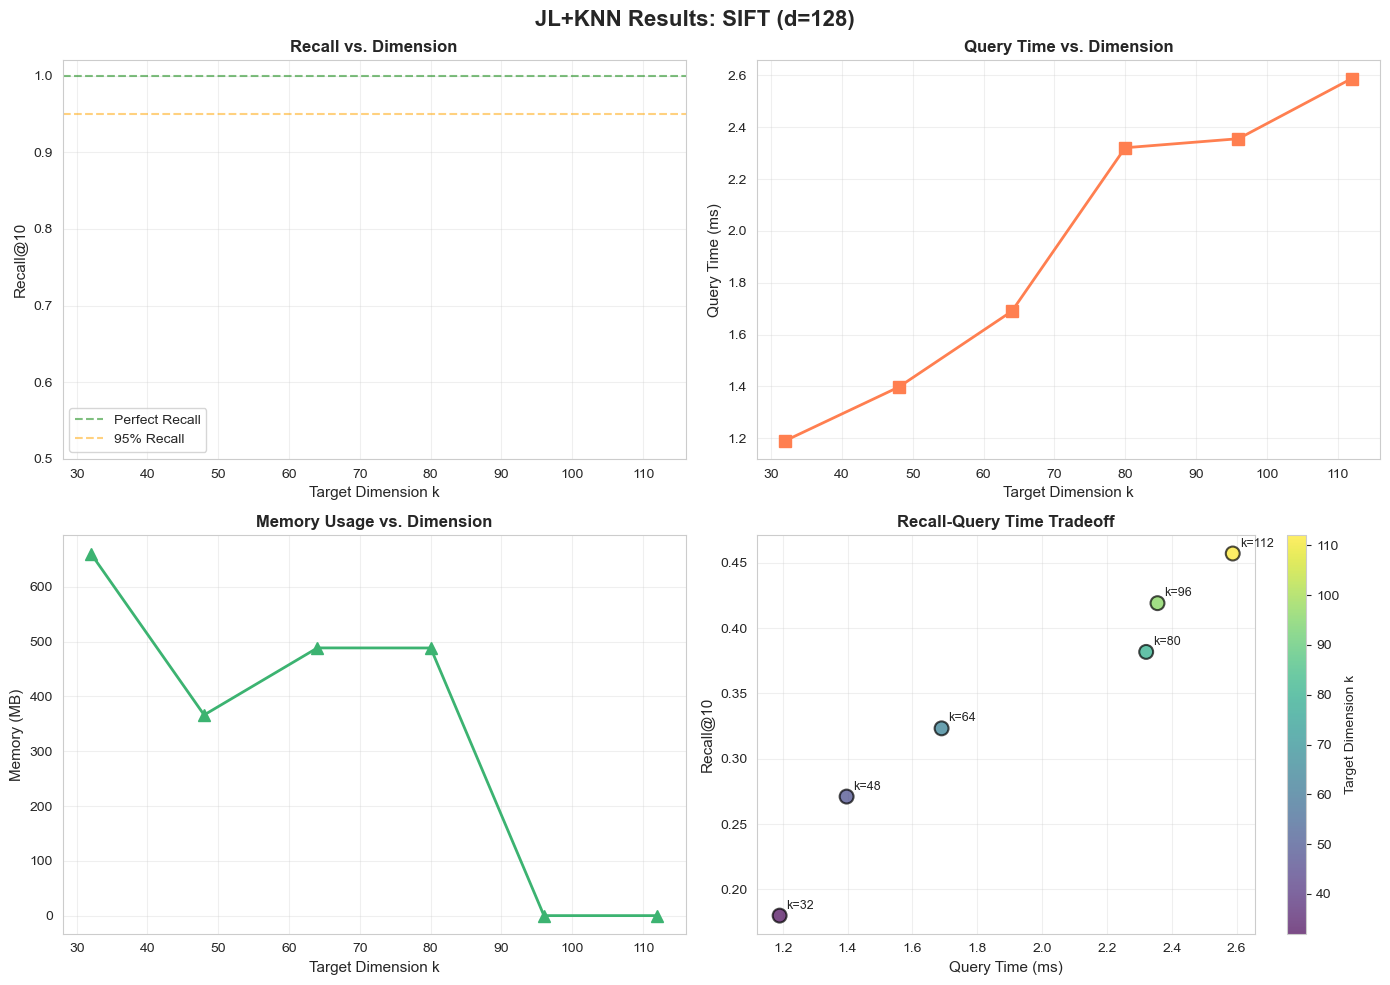

Plot saved to ../results/jl_knn_sift_tradeoffs.png

Plotting results for GIST...


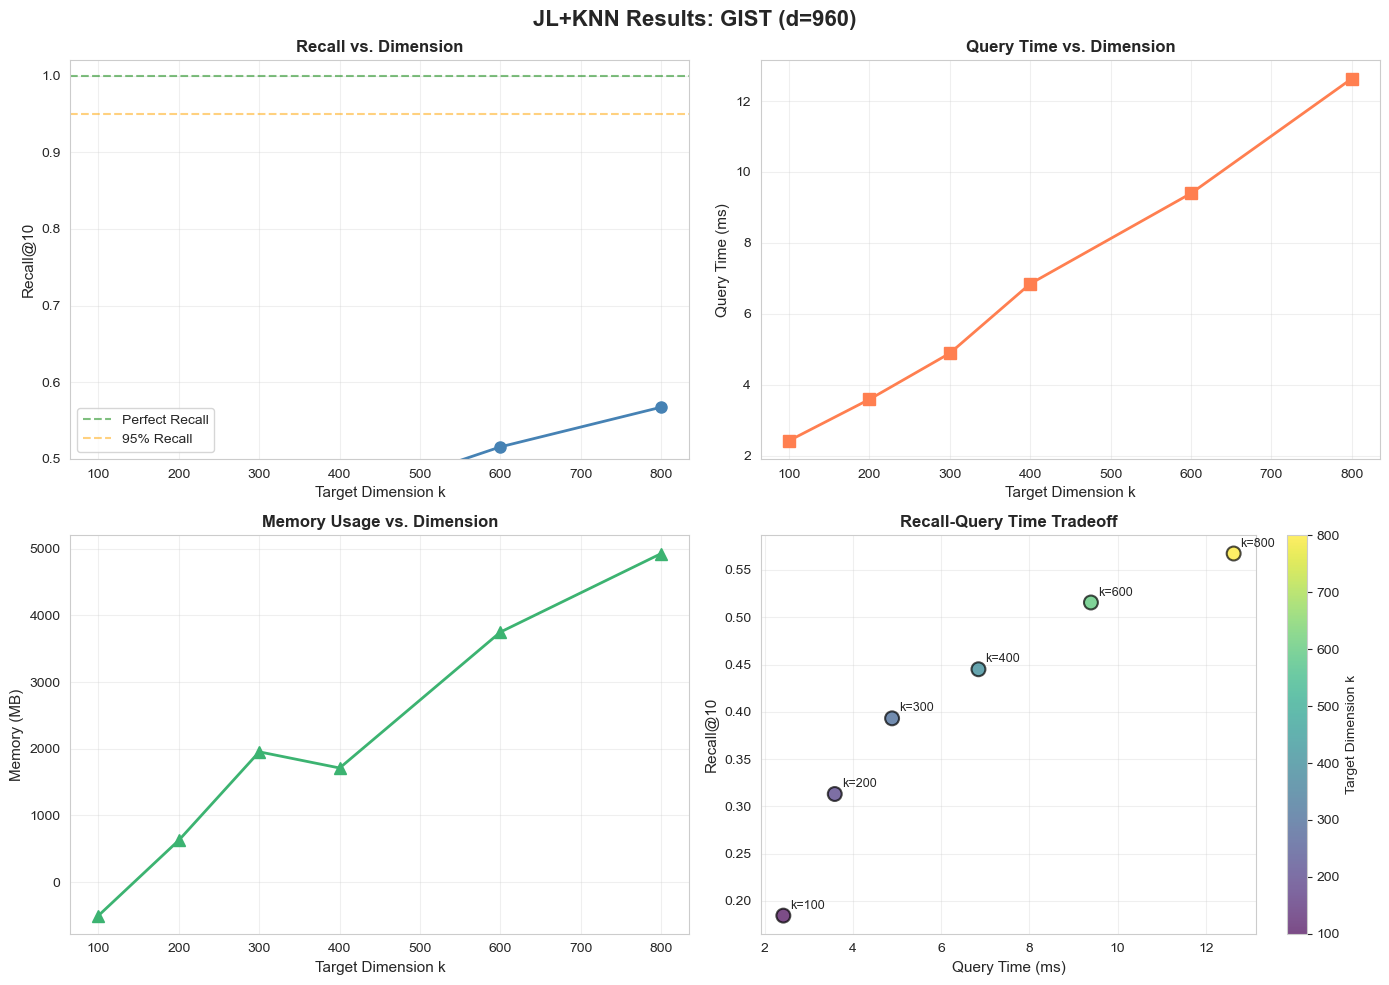

Plot saved to ../results/jl_knn_gist_tradeoffs.png

Plotting results for DEEP1B...


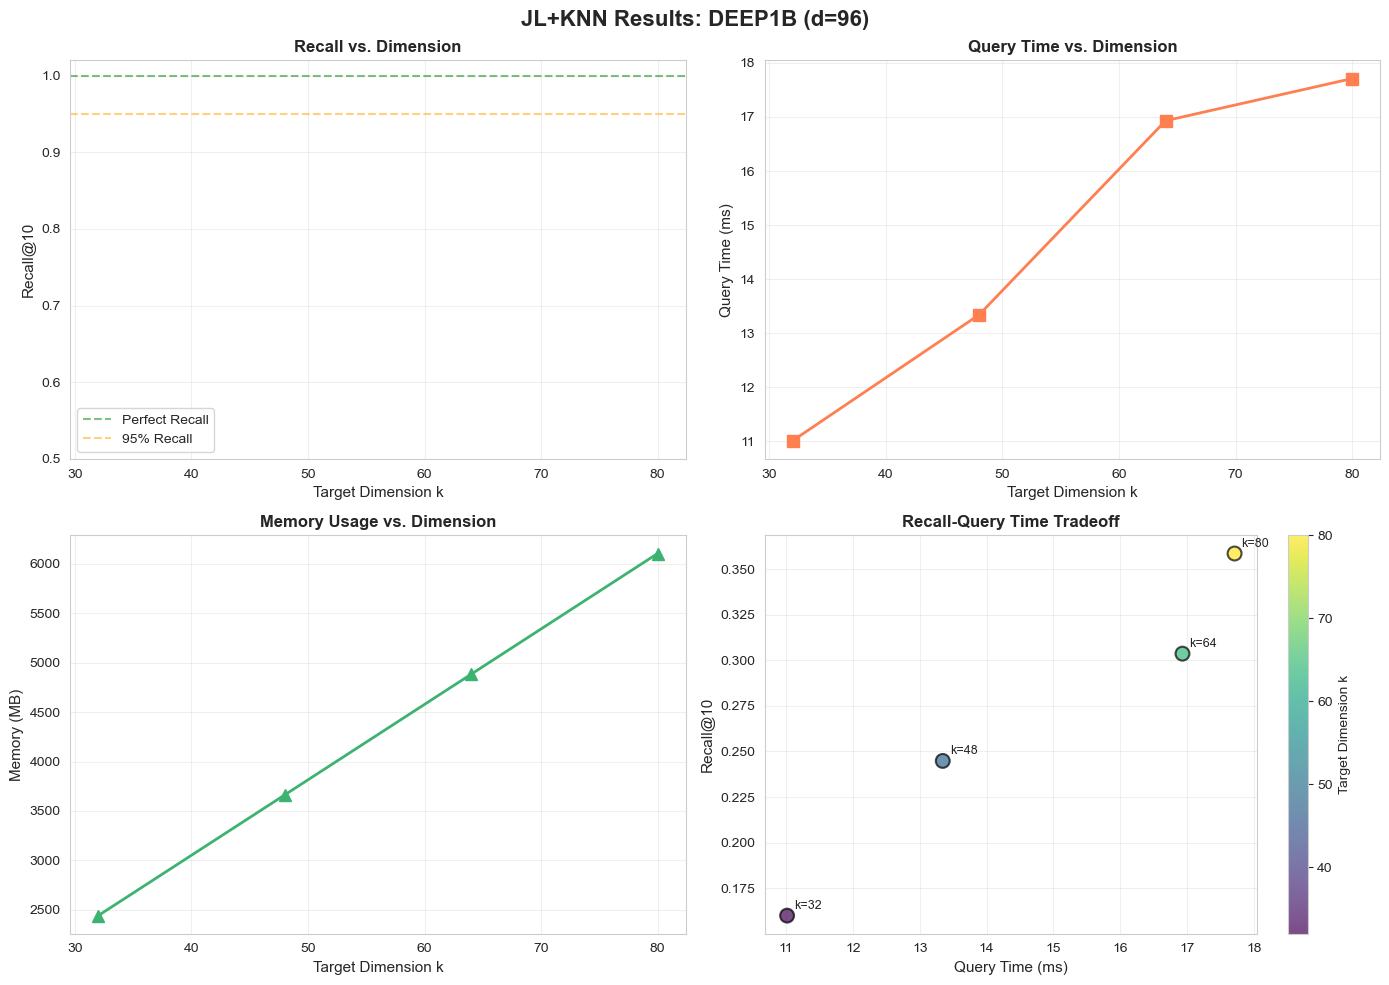

Plot saved to ../results/jl_knn_deep1b_tradeoffs.png


In [5]:
# Create per-dataset plots
for dataset_name, results_list in all_results.items():
    if not results_list:
        continue
    
    print(f"\nPlotting results for {dataset_name.upper()}...")
    
    # Extract data
    target_dims = [r['k_projected'] for r in results_list]
    recalls = [r['recall@k'] for r in results_list]
    query_times = [r['avg_query_time_ms'] for r in results_list]
    memories = [r['memory_mb'] for r in results_list]
    compression_ratios = [r['compression_ratio'] for r in results_list]
    d_orig = results_list[0]['d_original']
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'JL+KNN Results: {dataset_name.upper()} (d={d_orig})', fontsize=16, fontweight='bold')
    
    # 1. Recall vs Target Dimension
    axes[0, 0].plot(target_dims, recalls, marker='o', linewidth=2, markersize=8, color='steelblue')
    axes[0, 0].axhline(y=1.0, color='green', linestyle='--', alpha=0.5, label='Perfect Recall')
    axes[0, 0].axhline(y=0.95, color='orange', linestyle='--', alpha=0.5, label='95% Recall')
    axes[0, 0].set_xlabel('Target Dimension k', fontsize=11)
    axes[0, 0].set_ylabel(f'Recall@{K}', fontsize=11)
    axes[0, 0].set_title('Recall vs. Dimension', fontsize=12, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()
    axes[0, 0].set_ylim([max(0.5, min(recalls) - 0.05), 1.02])
    
    # 2. Query Time vs Target Dimension
    axes[0, 1].plot(target_dims, query_times, marker='s', linewidth=2, markersize=8, color='coral')
    axes[0, 1].set_xlabel('Target Dimension k', fontsize=11)
    axes[0, 1].set_ylabel('Query Time (ms)', fontsize=11)
    axes[0, 1].set_title('Query Time vs. Dimension', fontsize=12, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Memory vs Target Dimension
    axes[1, 0].plot(target_dims, memories, marker='^', linewidth=2, markersize=8, color='mediumseagreen')
    axes[1, 0].set_xlabel('Target Dimension k', fontsize=11)
    axes[1, 0].set_ylabel('Memory (MB)', fontsize=11)
    axes[1, 0].set_title('Memory Usage vs. Dimension', fontsize=12, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Recall vs Query Time (Pareto frontier)
    scatter = axes[1, 1].scatter(query_times, recalls, s=100, c=target_dims, 
                                cmap='viridis', alpha=0.7, edgecolors='black', linewidth=1.5)
    # Add labels for each point
    for i, k in enumerate(target_dims):
        axes[1, 1].annotate(f'k={k}', (query_times[i], recalls[i]), 
                           textcoords="offset points", xytext=(5,5), ha='left', fontsize=9)
    axes[1, 1].set_xlabel('Query Time (ms)', fontsize=11)
    axes[1, 1].set_ylabel(f'Recall@{K}', fontsize=11)
    axes[1, 1].set_title('Recall-Query Time Tradeoff', fontsize=12, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    cbar = plt.colorbar(scatter, ax=axes[1, 1])
    cbar.set_label('Target Dimension k', fontsize=10)
    
    plt.tight_layout()
    plot_path = os.path.join(RESULTS_DIR, f'jl_knn_{dataset_name}_tradeoffs.png')
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Plot saved to {plot_path}")

## 5. Cross-Dataset Comparison

Compare the best configuration from each dataset.

In [6]:
# Find best configuration for each dataset (highest recall)
best_configs = {}

for dataset_name, results_list in all_results.items():
    if not results_list:
        continue
    
    # Sort by recall (descending)
    sorted_results = sorted(results_list, key=lambda x: x['recall@k'], reverse=True)
    best_configs[dataset_name] = sorted_results[0]

if best_configs:
    print("\n" + "="*70)
    print("BEST CONFIGURATIONS (Highest Recall)")
    print("="*70 + "\n")
    
    for dataset_name, result in best_configs.items():
        print(f"{dataset_name.upper()}:")
        print(f"  Original dimension: {result['d_original']}")
        print(f"  Target dimension: {result['k_projected']}")
        print(f"  Compression ratio: {result['compression_ratio']:.2f}x")
        print(f"  Recall@{K}: {result['recall@k']:.4f}")
        print(f"  Query time: {result['avg_query_time_ms']:.3f} ms")
        print(f"  Memory: {result['memory_mb']:.3f} MB")
        print()


BEST CONFIGURATIONS (Highest Recall)

SIFT:
  Original dimension: 128
  Target dimension: 112
  Compression ratio: 1.14x
  Recall@10: 0.4571
  Query time: 2.588 ms
  Memory: 0.113 MB

GIST:
  Original dimension: 960
  Target dimension: 800
  Compression ratio: 1.20x
  Recall@10: 0.5674
  Query time: 12.634 ms
  Memory: 4929.152 MB

DEEP1B:
  Original dimension: 96
  Target dimension: 80
  Compression ratio: 1.20x
  Recall@10: 0.3585
  Query time: 17.710 ms
  Memory: 6103.645 MB



## 6. Summary Statistics Table

Create a comprehensive summary comparing all configurations.

In [7]:
# Flatten all results for summary
all_results_flat = []
for dataset_name, results_list in all_results.items():
    all_results_flat.extend(results_list)

if all_results_flat:
    print("\n" + "="*90)
    print("SUMMARY: ALL JL+KNN CONFIGURATIONS")
    print("="*90)
    
    # Header
    print(f"{'Dataset':<10} {'d→k':<12} {'Ratio':<8} {'Recall@10':<12} {'Query(ms)':<12} {'Memory(MB)':<12}")
    print("-" * 90)
    
    # Sort by dataset, then target dimension
    sorted_results = sorted(all_results_flat, key=lambda x: (x['dataset'], x['k_projected']))
    
    for r in sorted_results:
        dim_str = f"{r['d_original']}→{r['k_projected']}"
        ratio_str = f"{r['compression_ratio']:.2f}x"
        recall_str = f"{r['recall@k']:.4f}"
        query_str = f"{r['avg_query_time_ms']:.3f}"
        mem_str = f"{r['memory_mb']:.3f}"
        
        print(f"{r['dataset'].upper():<10} {dim_str:<12} {ratio_str:<8} {recall_str:<12} {query_str:<12} {mem_str:<12}")
    
    # Save comprehensive summary
    summary = {
        'experiment': 'JL + KNN',
        'k': K,
        'n_test': N_TEST,
        'jl_epsilon': JL_EPSILON,
        'configurations_tested': len(all_results_flat),
        'results_by_dataset': all_results
    }
    
    summary_path = os.path.join(RESULTS_DIR, 'jl_knn_summary.json')
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)
    
    print(f"\nComprehensive summary saved to {summary_path}")


SUMMARY: ALL JL+KNN CONFIGURATIONS
Dataset    d→k          Ratio    Recall@10    Query(ms)    Memory(MB)  
------------------------------------------------------------------------------------------
DEEP1B     96→32        3.00x    0.1600       11.015       2441.781    
DEEP1B     96→48        2.00x    0.2448       13.344       3662.449    
DEEP1B     96→64        1.50x    0.3036       16.931       4882.941    
DEEP1B     96→80        1.20x    0.3585       17.710       6103.645    
GIST       960→100      9.60x    0.1845       2.423        -502.902    
GIST       960→200      4.80x    0.3131       3.589        627.668     
GIST       960→300      3.20x    0.3931       4.888        1954.121    
GIST       960→400      2.40x    0.4450       6.847        1711.527    
GIST       960→600      1.60x    0.5156       9.397        3751.141    
GIST       960→800      1.20x    0.5674       12.634       4929.152    
SIFT       128→32       4.00x    0.1800       1.191        660.613     
SIFT     

## 7. Key Observations

**Expected Results:**
- Recall should decrease as target dimension k decreases
- Query time should decrease with lower k (fewer dimensions to compute)
- Memory usage should scale linearly with k
- JL works best for high-dimensional data (GIST) where compression ratio is high

**Tradeoffs:**
- **High k**: Better recall, but slower queries and more memory
- **Low k**: Faster queries and less memory, but lower recall
- **Sweet spot**: Find k where recall remains high (≥0.95) with significant speedup

**Next Steps:**
Compare these results against:
1. Baseline brute-force KNN (from notebook 01)
2. LSH without JL (notebook 03)
3. JL+LSH combination (future work)